In [1]:
from IPython.display import display, HTML
import os
import time
import pickle
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 300)
%matplotlib inline

def load_data(filename):
    with open(filename, 'rb') as fin:
        return pickle.load(fin)
    
def save_data(obj, filename):
    with open(filename, 'wb+') as fout:
        pickle.dump(obj, fout)
        
root_path = 'C:/Users/yuanl4/Documents/MelbDatathon2017/'

In [2]:
def merge_patients(i):
    df1 = pd.read_csv(root_path + 'Transactions/patients_%d.txt' % i, sep='\t')
    df2 = pd.read_csv(root_path + 'Missing/missing_patients_%d.txt' % i, sep='\t')
    df = pd.concat([df1, df2], axis=0, copy=False)
    df.drop_duplicates(inplace=True)
    df.sort_values(['Patient_ID', 'Dispense_Week'], inplace=True)
    df.set_index(np.arange(df.shape[0]), inplace=True)
    return df

In [44]:
%%time
transactions = []
for i in range(3, 5):
#     transactions.append(merge_patients(i))
    print('%d\t'%i, time.ctime())
    df = merge_patients(i)
    df = df[['Patient_ID', 'Store_ID', 'Prescriber_ID', 'Drug_ID', 'Prescription_Week', 'Dispense_Week',
             'PatientPrice_Amt', 'WholeSalePrice_Amt', 'GovernmentReclaim_Amt']] 
#      df.dropna(axis=0, how='any', subset=['PatientPrice_Amt', 'WholeSalePrice_Amt', 'GovernmentReclaim_Amt'],
#               inplace=True)
    df.to_csv(root_path + 'Final_summary/patient_%d.csv'%i, index=False)
print('finished.')

3	 Wed May  3 03:39:39 2017
4	 Wed May  3 03:39:53 2017
finished.
Wall time: 30 s


Fix over-large wholesale price

In [4]:
df = pd.read_csv(root_path + 'Final_summary/patient_9.csv')
print(df.WholeSalePrice_Amt.max())
df.loc[df.WholeSalePrice_Amt==1041874.5, 'WholeSalePrice_Amt'] = 1499.1
print(df.WholeSalePrice_Amt.max())

1041874.5
19367.69


In [5]:
df.to_csv(root_path + 'Final_summary/patient_9.csv', index=False)

read all patients

In [2]:
def read_patient(i):
    df = pd.read_csv(root_path + 'Final_summary/patient_%d.csv'%i)
    df.rename(columns={'Patient_ID':'PID', 'Store_ID':'SID', 'Prescriber_ID':'PresID', 'Drug_ID':'DID',
                       'Prescription_Week':'PresWeek', 'Dispense_Week':'DispWeek', 'PatientPrice_Amt':'PatientPrice',
                       'WholeSalePrice_Amt':'WholeSalePrice', 'GovernmentReclaim_Amt':'GovernmentReclaim'},
              inplace=True)
    return df

In [3]:
%%time
transactions = []
for i in range(1, 51):
    print(i, end=' ')
    transactions.append(read_patient(i))
print('finish loading')
transactions = pd.concat(transactions, ignore_index=True)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 finish loading
Wall time: 1min 1s


In [15]:
num_patients = transactions.PID.max()
print(num_patients)

558352


patient info

In [4]:
patient_lookup = pd.read_csv(root_path + 'Lookups/patients.txt', sep='\t', index_col='Patient_ID')

In [5]:
veteran_drug_transactions = transactions.loc[np.in1d(transactions.DID.values, [7427, 7428, 7429]), :]

In [26]:
# 7427: DVA DAA ONE MONTH SUITABILITY
# 7428: DVA DAA SIX MONTHS SUPPLY
# 7429: DVA VETERAN'S SIX MONTH REVIEW

# 7427 REPAT1 DVA DAA ONE MONTH SUITABILITY    83
# 7428 REPAT2 DVA DAA SIX MONTHS SUPPLY        29720
# 7429 REPAT3 DVA VETERAN'S SIX MONTH REVIEW   1097
np.unique(veteran_drug_transactions.DID.values, return_counts=True)

(array([7427, 7428, 7429], dtype=int64),
 array([   83, 29720,  1097], dtype=int64))

In [27]:
veteran_PIDs = veteran_drug_transactions.PID.unique()
len(veteran_PIDs)

179

In [33]:
veteran_PIDs

array([  8828,  12023,  13265,  16632,  17882,  19750,  20329,  30304,
        31858,  32892,  36355,  42346,  43026,  44099,  54476,  55192,
        60019,  64533,  71265,  73008,  78094,  84884,  85797,  87572,
        88001,  88154,  90520,  93746,  95833, 100264, 101611, 105879,
       110955, 119861, 121203, 123462, 127917, 131588, 134072, 134220,
       141479, 141841, 152122, 156250, 159443, 168954, 169484, 171245,
       174952, 178994, 179795, 181219, 190441, 193213, 200673, 203732,
       203737, 203779, 209878, 212121, 219214, 222741, 231229, 234259,
       235123, 235714, 237506, 248328, 248930, 255128, 264109, 264488,
       269229, 269238, 270534, 273062, 273622, 278557, 279962, 280637,
       282237, 284493, 285240, 287766, 288854, 291747, 293041, 293340,
       294072, 296003, 298784, 300952, 306220, 313067, 315645, 322667,
       324420, 329717, 330327, 333728, 334144, 335884, 339861, 340309,
       341907, 347745, 350795, 356428, 357338, 358735, 366981, 368795,
      

In [28]:
veteran_mask = np.in1d(transactions.PID.values, veteran_PIDs)

veteran_transactions = transactions.loc[veteran_mask, :]

In [41]:
len(veteran_transactions.PID.unique()), veteran_transactions.shape

(179, (170225, 9))

In [32]:
np.unique(patient_lookup.loc[veteran_PIDs, 'gender'].values, return_counts=True)

(array(['F', 'M', 'U'], dtype=object), array([96, 70, 13], dtype=int64))

In [44]:
trans_90353 = transactions.loc[transactions.PID==90353, :]

In [47]:
unique_drug_90353, count_drug_90353 = np.unique(trans_90353.DID.values, return_counts=True)

In [49]:
unique_drug_90353[np.argsort(count_drug_90353)], count_drug_90353[np.argsort(count_drug_90353)]

(array([11529,   863, 10823,  4420,   921, 12144, 10535, 11952, 11255,
         1383,  7339,  2885, 10595,  9895,  2877,  6358, 11666,  7083,
        11375, 11630,  2474, 11440, 11473,  6901,  2412,  2884, 12466,
        12272,  4540,  9530,  5357,  9535,   201,  9356,  5172,  5477,
         9015,   434, 11040, 10901, 12752,  6021, 10726,  8713,   766,
          765,   764,  2378, 10820,  6267,  4416, 11304, 10903,  6450,
         5205,  5476,  5509, 10828,  5584,  3028,  6353,  3786,  5738,
        13411,  8134,  7958,  6524,  7721,  9651,  7225,  9650,  1969,
          779, 11777, 12489,  1369,  9719,  8728,  9032,   331, 11568,
         9549,   295,  9009,  5175, 10829, 10545,  5291,  9470,   724,
        12702,  2294,  6336,  6561,  6694, 11458,  2102, 10369, 11377,
         3619,  7042, 11316,  5373,  2680,  3315,  6449,  9979,  7111,
         8725,  9540,  5438,  9749,  6936, 10093,  6032, 10547,  8440,
         9643, 13067,  5551,  9008,  9640,  7280,  5590, 10902,   223,
      

In [51]:
np.unique(trans_90353.loc[trans_90353.DID==6470, :].PresID.values, return_counts=True)

(array([    0,   652,  8461, 15621, 17013, 18275, 20765, 23921, 26444,
        27843, 29433, 31559, 41443, 53672, 54876, 57564, 60680], dtype=int64),
 array([ 6,  4, 10, 14,  1,  2, 18,  1,  1,  4, 13,  4,  3,  6,  3, 34, 17], dtype=int64))

In [61]:
trans_90353.columns

Index(['PID', 'SID', 'PresID', 'DID', 'PresWeek', 'DispWeek', 'PatientPrice',
       'WholeSalePrice', 'GovernmentReclaim'],
      dtype='object')

In [65]:
output = pd.DataFrame()
for i in trans_90353.loc[trans_90353.DID==6470, :].index:
    dispWeek = trans_90353.loc[i, 'DispWeek']
    presID = trans_90353.loc[i, 'PresID']
    if presID > 0:
        output.loc[dispWeek, presID] = 1

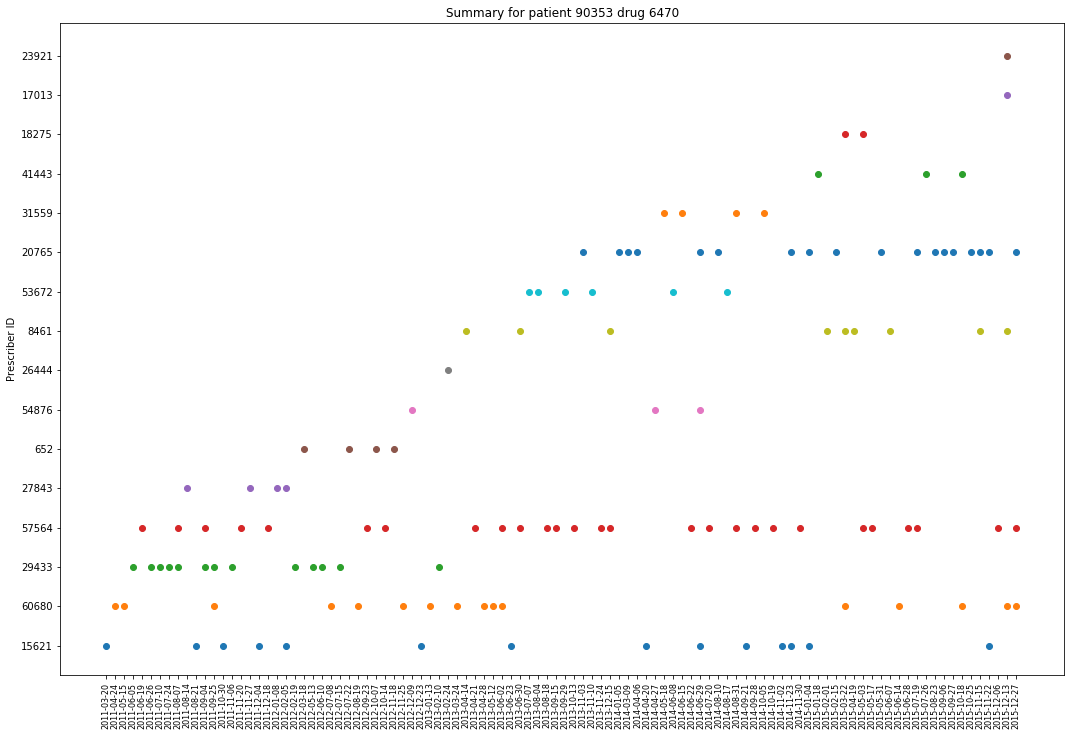

In [83]:
def draw():
    plt.title('Summary for patient 90353 drug 6470')
    for i, presID in enumerate(output.columns):
        plt.scatter(np.arange(len(output.index)), output[presID] + i)
    plt.ylabel('Prescriber ID')
    plt.yticks(np.arange(len(output.columns))+1, output.columns)
    plt.xticks(np.arange(len(output.index)), output.index, rotation='vertical', fontsize=8)
    plt.savefig('patient90353_drug_6470.png', bbox_inches='tight')
    plt.show()
draw()

In [84]:
transactions['Year'] = transactions.DispWeek.values.astype('datetime64[Y]').astype(int) + 1970

In [85]:
unique_year, encoded_year, count_year = np.unique(transactions.Year.values, return_inverse=True, return_counts=True)

In [88]:
PatientPrice      = np.bincount(encoded_year, transactions.PatientPrice.fillna(0).values)
GovernmentReclaim = np.bincount(encoded_year, transactions.GovernmentReclaim.fillna(0).values)
WholeSalePrice    = np.bincount(encoded_year, transactions.WholeSalePrice.fillna(0).values)
plot = pd.DataFrame(index=unique_year)
plot['PatientPrice'] = PatientPrice
plot['GovernmentReclaim'] = GovernmentReclaim
plot['WholeSalePrice'] = WholeSalePrice
plot['Transactions'] = count_year

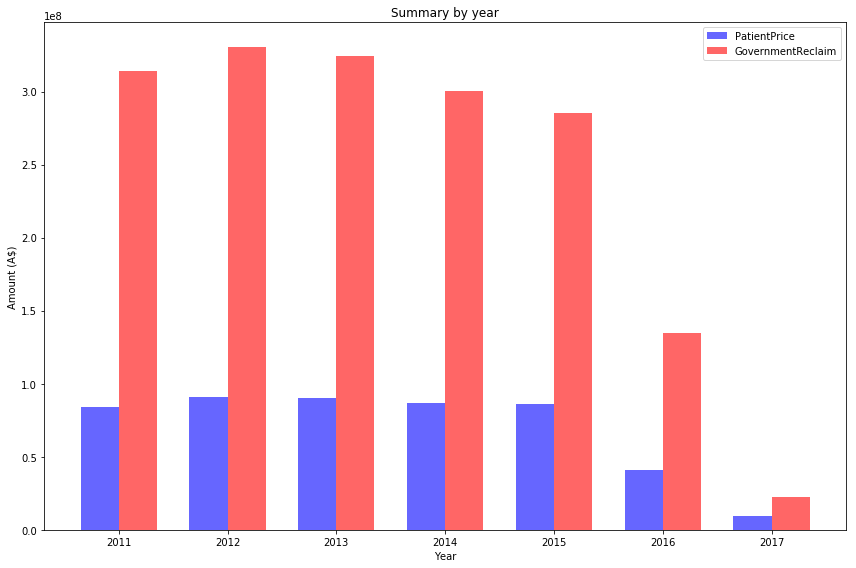

In [104]:
def plot_df(df):
    old_params = matplotlib.rcParams['figure.figsize']
    matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
    
    n_groups = df.shape[0]

    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    fig, ax1 = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.6

    rects1 = ax1.bar(index, df.PatientPrice, bar_width,
                     alpha=opacity, label='PatientPrice', color='blue')
    
    rects3 = ax1.bar(index + bar_width, df.GovernmentReclaim, bar_width,
                     alpha=opacity, label='GovernmentReclaim', color='red')


    ax1.set_ylabel('Amount (A$)')
#     ax1.set_ylim(0, 5e8)
    
#     ax2 = ax1.twinx()
#     ax2.plot(index + bar_width / 2, df.Transactions, lw=2, color='black')
#     ax2.set_ylabel('Transactions')
#     ax2.set_ylim(0.8e7, 1.2e7)

    plt.xlabel('Year')
    plt.xticks(index + bar_width / 2, df.index)
    
    plt.title('Summary by year')
    # ask matplotlib for the plotted objects and their labels
#     lines1, labels1 = ax1.get_legend_handles_labels()
#     lines2, labels2 = ax2.get_legend_handles_labels()
#     ax2.legend(lines1 + lines2, labels1 + labels2, loc=0)

    plt.legend()
    plt.tight_layout()
    plt.show()
    
    fig.savefig('test.png', bbox_inches='tight')
    
    matplotlib.rcParams['figure.figsize'] = old_params
plot_df(plot.loc[2011:2017])

In [122]:
drug_lookup = pd.read_csv('./Lookups/Drug_LookUp_CN.csv', encoding='utf-16', sep='\t', index_col='MasterProductID', 
                          usecols=['MasterProductID', 'MasterProductFullName', 
                                   'FormCode', 'StrengthCode', 'PackSizeNumber',
                                   'ATCLevel5Code', 'L1_CN', 'L2_CN', 'L3_CN', 'L4_CN', 'L5_CN'])
drug_lookup.index.rename('DID', inplace=True)
np.unique(drug_lookup.FormCode.fillna('NA').values, return_counts=True)

(array(['A-CAPS', 'A-HALER', 'AER-SPR', 'AMP', 'APP', 'AUTO-INJ', 'AUTOH',
        'BAR', 'BATH-OIL', 'CAP', 'CAPLET', 'CD-CAP', 'CHEW-TAB',
        'CHEW-TABS', 'CR-CAP', 'CR-TAB', 'CRM', 'D-TAB', 'DISKS',
        'DISP-TAB', 'DRES', 'EAR-DRP', 'EAR-OINT', 'EC-TABS', 'EFF-TAB',
        'ELIX', 'ELIX-C', 'ENEMA', 'ER-TAB', 'EXPECT', 'EYE-DRP', 'EYE-GEL',
        'EYE-OINT', 'EYE-SPR', 'GEL', 'GRAN', 'IMP', 'INF', 'INH',
        'INH-CAP', 'INHL', 'INJ', 'IRR', 'IUD', 'IV', 'IV-SOLN', 'JEL',
        'KIT', 'LINCT', 'LINM', 'LIQ', 'LOT', 'LOZ', 'M-WASH', 'MET-AERO',
        'MET-INHR', 'MIN', 'MIXT', 'MR-TAB', 'MSPR', 'NA', 'NAS-DRP',
        'NAS-OINT', 'NAS-SOLN', 'NAS-SPR', 'NAS-SPRY', 'NAS-SPY',
        'NEB-SOLN', 'O-DRP', 'O-DRPS', 'O-LIQ', 'O-PACK', 'O-PK',
        'O-SEMISOL', 'O-SOLN', 'OIL', 'OINT', 'OR-DISTAB', 'OR-GEL',
        'OR-SUSP', 'ORAL-LIQ', 'P-AMP', 'PACK', 'PAINT', 'PESS', 'PFP',
        'PFS', 'POWD', 'PSTE', 'PTCH', 'PWDR', 'R-CAPS', 'RECT-FOAM',
        'RESP', 

In [124]:
unique_StrengthCode, count_StrenthCode = np.unique(drug_lookup.StrengthCode.fillna('NA'), return_counts=True)

In [125]:
len(unique_StrengthCode)

1415

In [5]:
transactions.PID.max(), transactions.PID.min()

(558352, 1)

In [8]:
unique_genders, count_genders = np.unique(patient_lookup.gender.values, return_counts=True)
print(unique_genders, count_genders, count_genders/count_genders.sum())

['F' 'M' 'U'] [257706 184550 116096] [ 0.46154755  0.33052626  0.20792618]


In [10]:
unqiue_presID, count_presID = np.unique(transactions.PresID, return_counts=True)
print(unqiue_presID, unqiue_presID.shape[0], count_presID)

[-9999     0     1 ..., 64487 64488 64489] 60259 [  17284 2326656      32 ...,      53      32     193]


In [11]:
unique_SID, count_SID = np.unique(transactions.SID, return_counts=True)
print(unique_SID, unique_SID.shape[0], count_SID)

[-9999     1     2 ...,  2820  2821  2822] 2814 [388986  18617  28995 ...,  24686  78434  36088]


In [14]:
def basic_info(values):
    unique, count = np.unique(values, return_counts=True)
    print(unique, unique.shape[0], count)

In [15]:
basic_info(transactions.DID.values)

[   -4    -3    -2 ..., 13788 13840 13848] 7936 [41336 30800  2957 ...,     4     1     1]


In [18]:
print('%lf\t%lf\t%lf' % (
    transactions.PatientPrice.sum(), transactions.GovernmentReclaim.sum(), transactions.WholeSalePrice.sum())
     )

488092559.462000	1711784160.610998	1591384420.909997


In [14]:
tcnt_by_patient = np.bincount(transactions.PID.values-1)

In [19]:
for x in zip((np.arange(num_patients)[tcnt_by_patient >= 3000] + 1), tcnt_by_patient[tcnt_by_patient >= 3000]):
    print('%d \t%d' % x)

19207 	3003
70778 	3106
90353 	4556
101611 	3225
172716 	3854
190200 	3436
268774 	3876
276377 	3374
308267 	3726
392225 	3092


In [82]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18.0, 12.0)

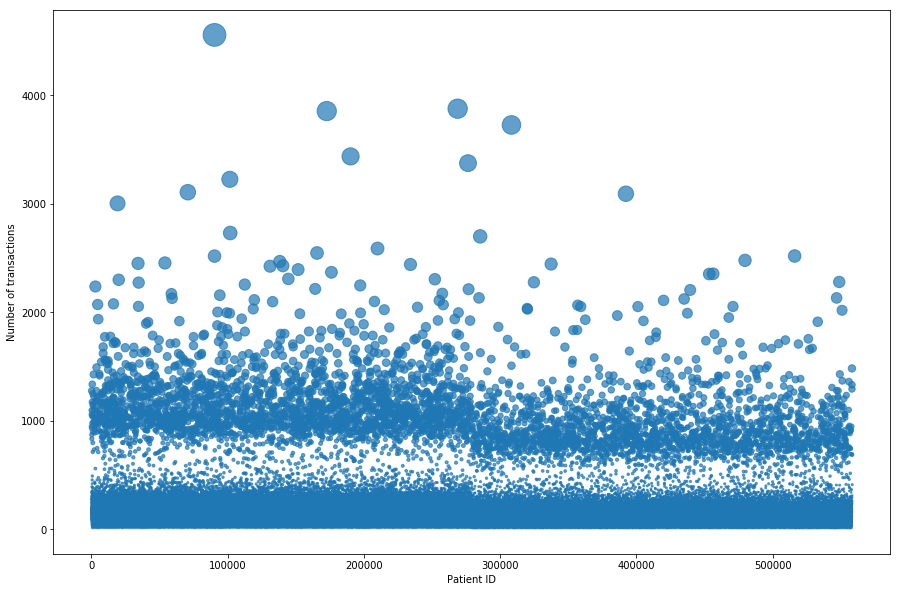

In [21]:
fig, ax = plt.subplots()
plt.scatter(np.arange(tcnt_by_patient.shape[0]), tcnt_by_patient, marker='o', s=(tcnt_by_patient/200)**2, alpha=0.7)
plt.ylabel('Number of transactions')
plt.xlabel('Patient ID')
plt.show()
fig.savefig('test.png', bbox_inches='tight')

In [34]:
reclaim_by_patient = np.bincount(transactions.PID.values-1, transactions.GovernmentReclaim.fillna(0))

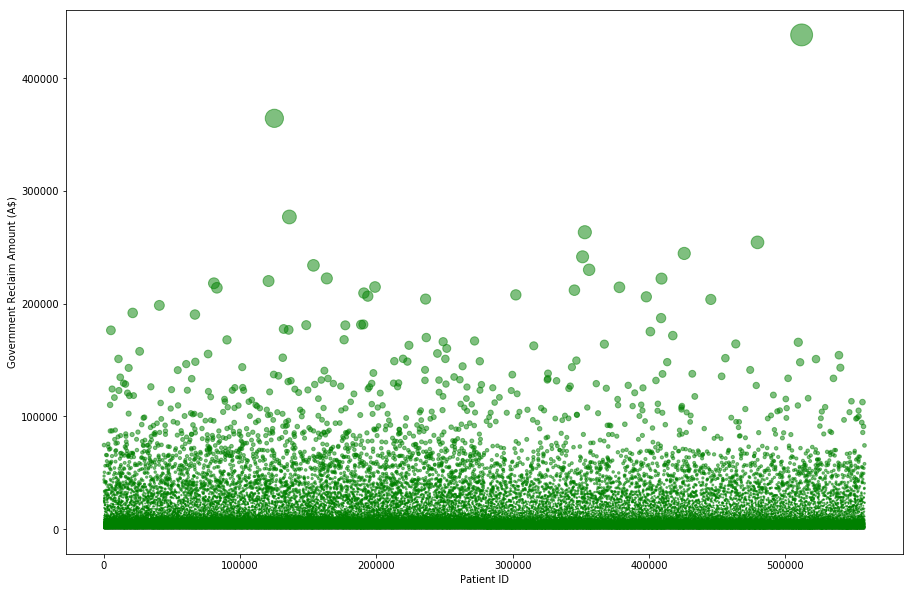

In [54]:
fig, ax = plt.subplots()
plt.scatter(np.arange(reclaim_by_patient.shape[0]), reclaim_by_patient, c='green',
            marker='o', s=(reclaim_by_patient/20000)**2, alpha=0.5)
plt.ylabel('Government Reclaim Amount (A$)')
plt.xlabel('Patient ID')
plt.show()
fig.savefig('test.png', bbox_inches='tight')

In [55]:
tcnt_by_patient[90352], reclaim_by_patient[90352]

(4556, 167850.3299999997)

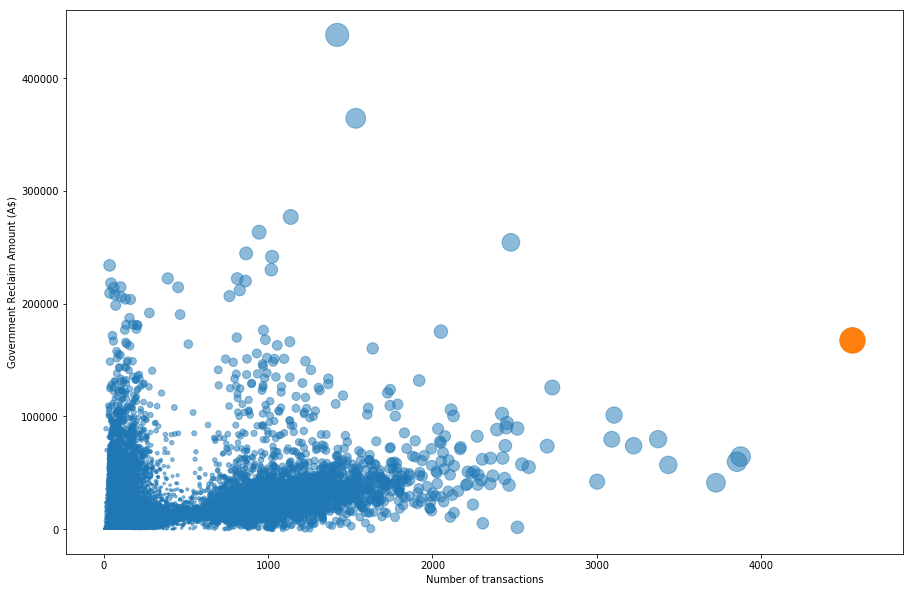

In [58]:
fig, ax = plt.subplots()
ax.scatter(tcnt_by_patient, reclaim_by_patient, alpha=0.5, s=(reclaim_by_patient/20000)**2 + (tcnt_by_patient/200)**2)
ax.scatter(tcnt_by_patient[90352], reclaim_by_patient[90352], 
           s=(reclaim_by_patient[90352]/20000)**2 + (tcnt_by_patient[90352]/200)**2 + 50)
plt.ylabel('Government Reclaim Amount (A$)')
plt.xlabel('Number of transactions')
plt.show()
fig.savefig('test.png', bbox_inches='tight')